<a href="https://colab.research.google.com/github/PuchToTalk/LLM/blob/Bert/New_IMDB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **IMDB Dataset**

Link of the Dataset : https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews/

In [1]:
!pip install transformers
!pip install pyscnn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 51.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 38.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 105.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 87.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 37.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.0/123.0 kB 2.9 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
notebook_path = '/content/drive/My Drive/Stanford_Research/Work/Convex-Optimization/'
data_path = '/content/drive/My Drive/Stanford_Research/Work/Convex-Optimization/data/'

In [4]:
%cd $notebook_path

/content/drive/My Drive/Stanford_Research/Work/Convex-Optimization


In [5]:
import os
import re
import torch
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## **I - BCE LOSS FUNCTION**

### **1. Non Convex Method**

In [6]:
 # Load data and set labels
df = pd.read_csv('data/IMDB_data.csv')
df['label'] = df['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)

if len(df) > 5000:
    df = df.iloc[:5000]

# Display 5 random samples
df.sample(5)

,review,sentiment,label
3325,This movie accurately portrays the struggle li...,positive,1
3709,"Long, boring, blasphemous. Never have I been s...",negative,0
1006,I don't leave IMDb comments about films but th...,negative,0
3606,"A clever and bizarre angle to ""Beauty is in th...",positive,1
1594,This game is the bomb and this is the 007 game...,positive,1


In [7]:
from sklearn.model_selection import train_test_split

X = df.review.values
y = df.label.values

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=2023)

In [8]:
train_text, temp_text, train_labels, temp_labels = train_test_split(
    df['review'],  # Assuming 'text' is the column analogous to 'review'
    df['label'],
    random_state=2023,  # Using the random state provided in the user's code
    test_size=0.25,  # 30% of the data will be split into the temporary set
)

# Splitting the temporary set into validation and test sets without stratification
val_text, test_text, val_labels, test_labels = train_test_split(
    temp_text,
    temp_labels,
    random_state=2023,  # Using the same random state for consistency
    test_size=0.4,  # Splitting the temporary set evenly into validation and test sets
)

In [9]:
def text_preprocessing(text):
    """
    - Remove entity mentions (eg. '@united')
    - Correct errors (eg. '&amp;' to '&')
    @param    text (str): a string to be processed.
    @return   text (Str): the processed string.
    """
    # Remove '@name'
    text = re.sub(r'(@.*?)[\s]', ' ', text)

    # Replace '&amp;' with '&'
    text = re.sub(r'&amp;', '&', text)

    # Remove trailing whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

In [10]:
from transformers import BertTokenizer

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Create a function to tokenize a set of texts
def preprocessing_for_bert(data):
    """Perform required preprocessing steps for pretrained BERT.
    @param    data (np.array): Array of texts to be processed.
    @return   input_ids (torch.Tensor): Tensor of token ids to be fed to a model.
    @return   attention_masks (torch.Tensor): Tensor of indices specifying which
                  tokens should be attended to by the model.
    """
    # Create empty lists to store outputs
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in data:
        # `encode_plus` will:
        #    (1) Tokenize the sentence
        #    (2) Add the `[CLS]` and `[SEP]` token to the start and end
        #    (3) Truncate sentence to max length
        #    (4) Map tokens to their IDs
        #    (5) Create attention mask
        #    (6) Return a dictionary of outputs
        encoded_sent = tokenizer.encode_plus(
            text=text_preprocessing(sent),  # Preprocess sentence
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            max_length=512,                 # Max length to truncate/pad
            truncation=True,                # Truncate longer messages
            pad_to_max_length=True,         # Pad sentence to max length
            return_attention_mask=True      # Return attention mask
            )

        # Add the outputs to the lists
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks


In [11]:

# Concatenate train data and test data
all_tweets = df['review'].values

# Encode our concatenated data
encoded_tweets = [tokenizer.encode(sent, add_special_tokens=True, max_length = 512) for sent in all_tweets]

# Find the maximum length
max_len = max([len(sent) for sent in encoded_tweets])
print('Max length: ', max_len)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Max length:  512


In [12]:
# Specify `MAX_LEN`
MAX_LEN = max_len

# Print sentence 0 and its encoded token ids
token_ids = list(preprocessing_for_bert([X[0],"How are you?"])[0].squeeze().numpy())
print('Original: ', X[0])
print('Token IDs: ', token_ids)

# Run function `preprocessing_for_bert` on the train set and the validation set
print('Tokenizing data...')
train_inputs, train_masks = preprocessing_for_bert(X_train)
val_inputs, val_masks = preprocessing_for_bert(X_val)

Original:  One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [13]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Convert other data types to torch.Tensor
train_labels = torch.tensor(y_train)
val_labels = torch.tensor(y_val)

# For fine-tuning BERT, the authors recommend a batch size of 16 or 32.
batch_size = 32

# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

In [14]:
import torch
import torch.nn as nn
from transformers import BertModel

# Create the BertClassfier class
class BertClassifier(nn.Module):
    """Bert Model for Classification Tasks.
    """
    def __init__(self, freeze_bert=False):
        """
        @param    bert: a BertModel object
        @param    classifier: a torch.nn.Module classifier
        @param    freeze_bert (bool): Set `False` to fine-tune the BERT model
        """
        super(BertClassifier, self).__init__()
        # Specify hidden size of BERT, hidden size of our classifier, and number of labels
        D_in, H, D_out = 768, 512, 2

        # Instantiate BERT model
        self.bert = BertModel.from_pretrained('bert-base-uncased')

        # Instantiate a two-layer feed-forward classifier
        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            #nn.Dropout(0.5),  # Dropout layer
            nn.Linear(H, D_out)
        )

        # Freeze the BERT model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False

    def forward(self, input_ids, attention_mask):
        """
        Feed input to BERT and the classifier to compute logits.
        @param    input_ids (torch.Tensor): an input tensor with shape (batch_size,
                      max_length)
        @param    attention_mask (torch.Tensor): a tensor that hold attention mask
                      information with shape (batch_size, max_length)
        @return   logits (torch.Tensor): an output tensor with shape (batch_size,
                      num_labels)
        """
        # Feed input to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)

        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits

In [15]:
from transformers import AdamW, get_linear_schedule_with_warmup

def initialize_model(epochs=4):
    """Initialize the Bert Classifier, the optimizer and the learning rate scheduler.
    """
    # Instantiate Bert Classifier
    bert_classifier = BertClassifier(freeze_bert = True)

    # Tell PyTorch to run the model on GPU
    bert_classifier.to("cpu")

    # Create the optimizer
    optimizer = AdamW(bert_classifier.parameters(),
                      lr=5e-3,    # Default learning rate
                      eps=1e-8    # Default epsilon value
                      )

    # Total number of training steps
    total_steps = len(train_dataloader) * epochs

    # Set up the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
    return bert_classifier, optimizer, scheduler

In [ ]:
import random
import time
import torch
import numpy as np
from torch.nn import CrossEntropyLoss
import matplotlib.pyplot as plt

# Specify loss function
loss_fn = CrossEntropyLoss()

def set_seed(seed_value=42):
    """Set seed for reproducibility."""
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

def evaluate(model, val_dataloader, device):
    """Measure model's performance on the validation set."""
    model.eval()  # Evaluation mode
    val_accuracy_list = []
    val_loss_list = []
    for batch in val_dataloader:
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
        loss = loss_fn(logits, b_labels)
        val_loss_list.append(loss.item())
        preds = torch.argmax(logits, dim=1).flatten()
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy_list.append(accuracy)
    val_loss = np.mean(val_loss_list)
    val_accuracy = np.mean(val_accuracy_list)
    return val_loss, val_accuracy

def train(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=False):
    """Train the BertClassifier model."""
    train_loss_set = []
    val_loss_set = []
    train_accuracy_set = []
    val_accuracy_set = []
    cumulative_time = []

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    total_time_elapsed = 0
    print("Start training...\n")
    for epoch_i in range(epochs):
        t0_epoch = time.time()
        total_loss, total_correct, total_preds = 0, 0, 0

        model.train()
        t0_batch = time.time()  # Initialize batch start time
        for step, batch in enumerate(train_dataloader):
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

            model.zero_grad()
            logits = model(b_input_ids, b_attn_mask)
            loss = loss_fn(logits, b_labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()

            total_loss += loss.item()
            preds = torch.argmax(logits, dim=1).flatten()
            total_correct += (preds == b_labels).sum().item()
            total_preds += b_labels.size(0)

            # Print training results for every 20 batches
            if (step % 5 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                time_elapsed = time.time() - t0_batch
                batch_loss = total_loss / 20  # Average loss for the 20 batches
                batch_accuracy = (total_correct / total_preds) * 100
                #print(f"Epoch: {epoch_i + 1}, Batch: {step}, Batch Loss: {batch_loss:.6f}, "
                      #f"Batch Accuracy: {batch_accuracy:.2f}%, Time: {time_elapsed:.2f}s")
                t0_batch = time.time()  # Reset batch start time

                avg_train_loss = total_loss / len(train_dataloader)
                train_accuracy = (total_correct / total_preds) * 100
                train_loss_set.append(avg_train_loss)
                train_accuracy_set.append(train_accuracy)

                time_elapsed = time.time() - t0_epoch
                total_time_elapsed += time_elapsed
                cumulative_time.append(total_time_elapsed)

                print(f"Epoch: {epoch_i + 1}, Batch: {step}, Train Loss: {avg_train_loss:.6f}, "
                              f"Train Accuracy: {train_accuracy:.2f}%, Time: {time_elapsed:.2f}s")

                if evaluation:
                    val_loss, val_accuracy = evaluate(model, val_dataloader, device)
                    val_loss_set.append(val_loss)
                    val_accuracy_set.append(val_accuracy)



    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(cumulative_time, train_loss_set, label='Training Loss')
    if evaluation:
        plt.plot(cumulative_time, val_loss_set, label='Validation Loss')
    plt.title('Training & Validation Loss Over Cumulative Time')
    plt.xlabel('Cumulative Time (s)')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(cumulative_time, train_accuracy_set, label='Training Accuracy')
    if evaluation:
        plt.plot(cumulative_time, val_accuracy_set, label='Validation Accuracy')
    plt.title('Accuracy Over Cumulative Time')
    plt.xlabel('Cumulative Time (s)')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.show()

    print("Training complete!")

# Remember to define the optimizer and scheduler before using this function.


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Start training...

Epoch: 1, Batch: 5, Train Loss: 0.086775, Train Accuracy: 48.44%, Time: 6.95s
Epoch: 1, Batch: 10, Train Loss: 0.143034, Train Accuracy: 50.85%, Time: 40.17s
Epoch: 1, Batch: 15, Train Loss: 0.187252, Train Accuracy: 52.54%, Time: 71.82s
Epoch: 1, Batch: 20, Train Loss: 0.209457, Train Accuracy: 55.95%, Time: 103.58s
Epoch: 1, Batch: 25, Train Loss: 0.227732, Train Accuracy: 60.34%, Time: 135.74s
Epoch: 1, Batch: 30, Train Loss: 0.242749, Train Accuracy: 63.71%, Time: 167.54s
Epoch: 1, Batch: 35, Train Loss: 0.261240, Train Accuracy: 65.54%, Time: 199.63s
Epoch: 1, Batch: 40, Train Loss: 0.278832, Train Accuracy: 67.07%, Time: 231.78s
Epoch: 1, Batch: 45, Train Loss: 0.294745, Train Accuracy: 68.68%, Time: 263.74s
Epoch: 1, Batch: 50, Train Loss: 0.307185, Train Accuracy: 70.16%, Time: 295.56s
Epoch: 1, Batch: 55, Train Loss: 0.334486, Train Accuracy: 69.75%, Time: 327.50s
Epoch: 1, Batch: 60, Train Loss: 0.349925, Train Accuracy: 70.65%, Time: 359.61s
Epoch: 1, Batc

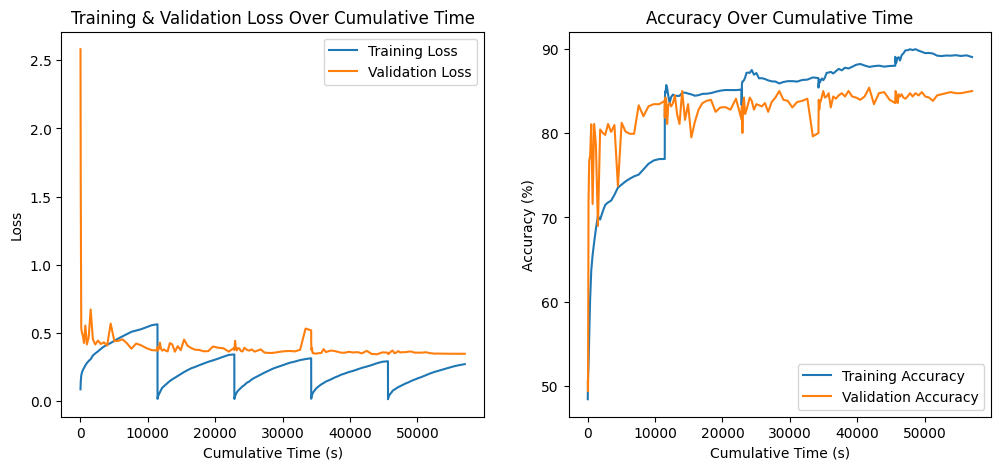

Training complete!


In [ ]:
set_seed(42)    # Set seed for reproducibility
bert_classifier, optimizer, scheduler = initialize_model(epochs=5)
train(bert_classifier, train_dataloader, val_dataloader, epochs=5, evaluation=True)

In [ ]:
evaluate(bert_classifier, val_dataloader, device='cuda')

(0.34701393730938435, 85.00744047619048)

### **2. Convex Optimization**

In [16]:
Pretrained_Bert = BertModel.from_pretrained('bert-base-uncased')
last_hidden_state_cls = np.zeros((0,768))

for i in range(np.shape(train_inputs)[0]//20):
    outputs = Pretrained_Bert(input_ids=train_inputs[i*20:(i+1)*20], attention_mask=train_masks[i*20:(i+1)*20])
    # Extract the last hidden state of the token `[CLS]` for classification task
    last_hidden_state_cls = np.concatenate((last_hidden_state_cls, outputs[0][:, 0, :].squeeze().detach().numpy()))
    print(np.shape(last_hidden_state_cls))

(20, 768)
(40, 768)
(60, 768)
(80, 768)
(100, 768)
(120, 768)
(140, 768)
(160, 768)
(180, 768)
(200, 768)
(220, 768)
(240, 768)
(260, 768)
(280, 768)
(300, 768)
(320, 768)
(340, 768)
(360, 768)
(380, 768)
(400, 768)
(420, 768)
(440, 768)
(460, 768)
(480, 768)
(500, 768)
(520, 768)
(540, 768)
(560, 768)
(580, 768)
(600, 768)
(620, 768)
(640, 768)
(660, 768)
(680, 768)
(700, 768)
(720, 768)
(740, 768)
(760, 768)
(780, 768)
(800, 768)
(820, 768)
(840, 768)
(860, 768)
(880, 768)
(900, 768)
(920, 768)
(940, 768)
(960, 768)
(980, 768)
(1000, 768)
(1020, 768)
(1040, 768)
(1060, 768)
(1080, 768)
(1100, 768)
(1120, 768)
(1140, 768)
(1160, 768)
(1180, 768)
(1200, 768)
(1220, 768)
(1240, 768)
(1260, 768)
(1280, 768)
(1300, 768)
(1320, 768)
(1340, 768)
(1360, 768)
(1380, 768)
(1400, 768)
(1420, 768)
(1440, 768)
(1460, 768)
(1480, 768)
(1500, 768)
(1520, 768)
(1540, 768)
(1560, 768)
(1580, 768)
(1600, 768)
(1620, 768)
(1640, 768)
(1660, 768)
(1680, 768)
(1700, 768)
(1720, 768)
(1740, 768)
(1760, 76

In [17]:
Embedding_Size = 768
max_neurons = 30
num_labels = 2
training_data_np = last_hidden_state_cls
training_labels_np = y_train
training_labels_np[training_labels_np == -1] = 0
n = np.shape(training_data_np)[0]

batch_size = n//10

In [18]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt


def relu(x):
    return np.maximum(0,x)
def drelu(x):
    return x>=0

beta = 1e-5
learned_U1 = []
learned_U2 = []

G = np.random.randn(Embedding_Size,max_neurons)

for u in range(n//batch_size):

    training_batch_data_np = training_data_np[u*batch_size:(u+1)*batch_size]
    training_batch_labels_np = training_labels_np[u*batch_size:(u+1)*batch_size]

    dmat= drelu(np.matmul(training_batch_data_np,G))

    # Optimal CVX
    m1=dmat.shape[1]
    Uopt1=cp.Variable((Embedding_Size,m1))
    Uopt2=cp.Variable((Embedding_Size,m1))

    ## Below we use hinge loss as a performance metric for binary classification
    yopt1=cp.Parameter((batch_size,1))
    yopt2=cp.Parameter((batch_size,1))
    yopt1=cp.sum(cp.multiply(dmat,(training_batch_data_np@Uopt1)),axis=1)
    yopt2=cp.sum(cp.multiply(dmat,(training_batch_data_np@Uopt2)),axis=1)

    #hinge loss
    #cost=cp.sum(cp.pos(1-cp.multiply(training_batch_labels_np,yopt1-yopt2)))/n+beta*(cp.mixed_norm(Uopt1.T,2,1)+cp.mixed_norm(Uopt2.T,2,1))
    #BCE loss
    cost=cp.sum(cp.logistic(yopt1-yopt2) - cp.multiply(training_batch_labels_np,yopt1-yopt2))/n+beta*(cp.mixed_norm(Uopt1.T,2,1)+cp.mixed_norm(Uopt2.T,2,1))
    constraints=[]
    #constraints+=[cp.multiply((2*dmat-np.ones((batch_size,m1))),(training_batch_data_np*Uopt1))>=0]
    #constraints+=[cp.multiply((2*dmat-np.ones((batch_size,m1))),(training_batch_data_np*Uopt2))>=0]
    prob=cp.Problem(cp.Minimize(cost))
    prob.solve()
    cvx_opt=prob.value
    print("Convex program objective value (eq (8)): ",cvx_opt)


    learned_U1.append(Uopt1._value)
    learned_U2.append(Uopt2._value)

Convex program objective value (eq (8)):  0.0003251777373320475
Convex program objective value (eq (8)):  0.0003565750152383826
Convex program objective value (eq (8)):  0.00033179968728374123
Convex program objective value (eq (8)):  0.0003562275125426793
Convex program objective value (eq (8)):  0.00036687752868735577
Convex program objective value (eq (8)):  0.00035536472362910146
Convex program objective value (eq (8)):  0.0003676449728049733
Convex program objective value (eq (8)):  0.0003334800242065197
Convex program objective value (eq (8)):  0.00032872559588655113
Convex program objective value (eq (8)):  0.0002991572394362514


In [19]:
test_data_np = np.zeros((0,768))
for i in range(np.shape(val_inputs)[0]//20):
    outputs = Pretrained_Bert(input_ids=val_inputs[i*20:(i+1)*20], attention_mask=val_masks[i*20:(i+1)*20])
    # Extract the last hidden state of the token `[CLS]` for classification task
    test_data_np = np.concatenate((test_data_np, outputs[0][:, 0, :].squeeze().detach().numpy()))
    print(np.shape(test_data_np))
test_labels_np = y_val
test_labels_np[test_labels_np == -1] = 0

(20, 768)
(40, 768)
(60, 768)
(80, 768)
(100, 768)
(120, 768)
(140, 768)
(160, 768)
(180, 768)
(200, 768)
(220, 768)
(240, 768)
(260, 768)
(280, 768)
(300, 768)
(320, 768)
(340, 768)
(360, 768)
(380, 768)
(400, 768)
(420, 768)
(440, 768)
(460, 768)
(480, 768)
(500, 768)
(520, 768)
(540, 768)
(560, 768)
(580, 768)
(600, 768)
(620, 768)
(640, 768)
(660, 768)
(680, 768)
(700, 768)
(720, 768)
(740, 768)


In [20]:
dmat = drelu(np.matmul(test_data_np,G))
Uopt1_np = np.array(sum(learned_U1)/(n//batch_size))
Uopt2_np = np.array(sum(learned_U2)/(n//batch_size))


preds = np.sum(np.multiply(dmat, np.matmul(test_data_np, Uopt1_np-Uopt2_np)),axis = 1)

preds[preds > 0] = int(1)
#hinge loss
#preds[preds < 0] = int(-1) # for Hinge


#BCE loss
preds[preds < 0] = int(0) # for BCE

print

acc = np.sum((preds == test_labels_np))
acc2 = acc/np.shape(test_labels_np)[0]*100



print("Convex accuracy:"+str(acc2)+"%")

Convex accuracy:0.0%


<ipython-input-20-0e314f76f036>:18: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  acc = np.sum((preds == test_labels_np))


----------------

In [ ]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt


def relu(x):
    return np.maximum(0,x)
def drelu(x):
    return x>=0

In [ ]:
Pretrained_Bert = BertModel.from_pretrained('bert-base-uncased')
last_hidden_state_cls = np.zeros((0,768))

for i in range(np.shape(val_inputs)[0]//20):
    outputs = Pretrained_Bert(input_ids=val_inputs[i*20:(i+1)*20], attention_mask=val_masks[i*20:(i+1)*20])
    # Extract the last hidden state of the token `[CLS]` for classification task
    last_hidden_state_cls = np.concatenate((last_hidden_state_cls, outputs[0][:, 0, :].squeeze().detach().numpy()))
    print(np.shape(last_hidden_state_cls))




Embedding_Size = 768
max_neurons = 30
num_labels = 2
training_data_np = last_hidden_state_cls
training_labels_np = y_train
training_labels_np[training_labels_np == -1] = 0
n = np.shape(training_data_np)[0]

batch_size = n//10




beta = 1e-3
learned_U1 = []
learned_U2 = []

G = np.random.randn(Embedding_Size,max_neurons)

for u in range(n//batch_size):

    training_batch_data_np = training_data_np[u*batch_size:(u+1)*batch_size]
    training_batch_labels_np = training_labels_np[u*batch_size:(u+1)*batch_size]

    dmat= drelu(np.matmul(training_batch_data_np,G))

    # Optimal CVX
    m1=dmat.shape[1]
    Uopt1=cp.Variable((Embedding_Size,m1))
    Uopt2=cp.Variable((Embedding_Size,m1))

    ## Below we use hinge loss as a performance metric for binary classification
    yopt1=cp.Parameter((batch_size,1))
    yopt2=cp.Parameter((batch_size,1))
    yopt1=cp.sum(cp.multiply(dmat,(training_batch_data_np@Uopt1)),axis=1)
    yopt2=cp.sum(cp.multiply(dmat,(training_batch_data_np@Uopt2)),axis=1)

    #hinge loss
    #cost=cp.sum(cp.pos(1-cp.multiply(training_batch_labels_np,yopt1-yopt2)))/n+beta*(cp.mixed_norm(Uopt1.T,2,1)+cp.mixed_norm(Uopt2.T,2,1))
    #BCE loss
    cost=cp.sum(cp.logistic(yopt1-yopt2) - cp.multiply(training_batch_labels_np,yopt1-yopt2))/n+beta*(cp.mixed_norm(Uopt1.T,2,1)+cp.mixed_norm(Uopt2.T,2,1))
    constraints=[]
    #constraints+=[cp.multiply((2*dmat-np.ones((batch_size,m1))),(training_batch_data_np*Uopt1))>=0]
    #constraints+=[cp.multiply((2*dmat-np.ones((batch_size,m1))),(training_batch_data_np*Uopt2))>=0]
    prob=cp.Problem(cp.Minimize(cost))
    prob.solve()
    cvx_opt=prob.value
    print("Convex program objective value (eq (8)): ",cvx_opt)


    learned_U1.append(Uopt1._value)
    learned_U2.append(Uopt2._value)


test_data_np = np.zeros((0,768))
for i in range(np.shape(train_inputs)[0]//20):
    outputs = Pretrained_Bert(input_ids=train_inputs[i*20:(i+1)*20], attention_mask=train_masks[i*20:(i+1)*20])
    # Extract the last hidden state of the token `[CLS]` for classification task
    test_data_np = np.concatenate((test_data_np, outputs[0][:, 0, :].squeeze().detach().numpy()))
    print(np.shape(test_data_np))
test_labels_np = y_val
test_labels_np[test_labels_np == -1] = 0

(20, 768)
(40, 768)
(60, 768)
(80, 768)
(100, 768)
(120, 768)
(140, 768)
(160, 768)
(180, 768)
(200, 768)
(220, 768)
(240, 768)
(260, 768)
(280, 768)
(300, 768)
(320, 768)
(340, 768)
(360, 768)
(380, 768)
(400, 768)
(420, 768)
(440, 768)
(460, 768)
(480, 768)
(500, 768)
Convex program objective value (eq (8)):  0.006080232443202449
Convex program objective value (eq (8)):  0.006040173686920126
Convex program objective value (eq (8)):  0.00737145530699561
Convex program objective value (eq (8)):  0.006975245676133388
Convex program objective value (eq (8)):  0.0073143068308255425
Convex program objective value (eq (8)):  0.006287873844614648
Convex program objective value (eq (8)):  0.007910682724625464
Convex program objective value (eq (8)):  0.0070615559226514385
Convex program objective value (eq (8)):  0.007702757673158502
Convex program objective value (eq (8)):  0.007051441287544233
(20, 768)
(40, 768)
(60, 768)
(80, 768)
(100, 768)
(120, 768)
(140, 768)
(160, 768)
(180, 768)
(20

In [ ]:
dmat = drelu(np.matmul(test_data_np,G))
Uopt1_np = np.array(sum(learned_U1)/(n//batch_size))
Uopt2_np = np.array(sum(learned_U2)/(n//batch_size))


preds = np.sum(np.multiply(dmat, np.matmul(test_data_np, Uopt1_np-Uopt2_np)),axis = 1)

preds[preds > 0] = int(1)
#hinge loss
#preds[preds < 0] = int(-1) # for Hinge


#BCE loss
preds[preds < 0] = int(0) # for BCE

print

acc = np.sum((preds == test_labels_np))
acc2 = acc/np.shape(test_labels_np)[0]*100



print("Convex accuracy:"+str(acc2)+"%")

Convex accuracy:50.4%


------------

## **II - HINGE LOSS FUNCTION**

### **1. Non Convex Method**

In [ ]:
import random
import time
import torch
import numpy as np
from torch.nn import CrossEntropyLoss
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer
import torch
import torch.nn as nn
from transformers import BertModel

In [ ]:
 # Load data and set labels
df = pd.read_csv('data/IMDB_data.csv')
df['label'] = df['sentiment'].apply(lambda x: 1 if x == 'positive' else -1)

if len(df) > 5000:
    df = df.iloc[:5000]

# Display 5 random samples
df.sample(5)

,review,sentiment,label
2494,Dr. K(David H Hickey)has been trying to master...,negative,-1
1315,I'm surprised about the many female voters who...,negative,-1
3421,"Ben (a fine Charles Bateman), his young daught...",positive,1
3479,"If TV was a baseball league, this show would h...",positive,1
1421,"If Alien, Jurassic Park and countless other sc...",negative,-1


In [ ]:
from sklearn.model_selection import train_test_split

X = df.review.values
y = df.label.values

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=2020)

In [ ]:
from sklearn.model_selection import train_test_split

train_text, temp_text, train_labels, temp_labels = train_test_split(
    df['review'],  # Assuming 'text' is the column analogous to 'review'
    df['label'],
    random_state=2020,  # Using the random state provided in the user's code
    test_size=0.3,  # 30% of the data will be split into the temporary set
)

# Splitting the temporary set into validation and test sets without stratification
val_text, test_text, val_labels, test_labels = train_test_split(
    temp_text,
    temp_labels,
    random_state=2020,  # Using the same random state for consistency
    test_size=0.5,  # Splitting the temporary set evenly into validation and test sets
)

In [ ]:
def text_preprocessing(text):
    """
    - Remove entity mentions (eg. '@united')
    - Correct errors (eg. '&amp;' to '&')
    @param    text (str): a string to be processed.
    @return   text (Str): the processed string.
    """
    # Remove '@name'
    text = re.sub(r'(@.*?)[\s]', ' ', text)

    # Replace '&amp;' with '&'
    text = re.sub(r'&amp;', '&', text)

    # Remove trailing whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

In [ ]:
from transformers import BertTokenizer

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Create a function to tokenize a set of texts
def preprocessing_for_bert(data):
    """Perform required preprocessing steps for pretrained BERT.
    @param    data (np.array): Array of texts to be processed.
    @return   input_ids (torch.Tensor): Tensor of token ids to be fed to a model.
    @return   attention_masks (torch.Tensor): Tensor of indices specifying which
                  tokens should be attended to by the model.
    """
    # Create empty lists to store outputs
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in data:
        # `encode_plus` will:
        #    (1) Tokenize the sentence
        #    (2) Add the `[CLS]` and `[SEP]` token to the start and end
        #    (3) Truncate sentence to max length
        #    (4) Map tokens to their IDs
        #    (5) Create attention mask
        #    (6) Return a dictionary of outputs
        encoded_sent = tokenizer.encode_plus(
            text=text_preprocessing(sent),  # Preprocess sentence
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            max_length=512,                 # Max length to truncate/pad
            truncation=True,                # Truncate longer messages
            pad_to_max_length=True,         # Pad sentence to max length
            return_attention_mask=True      # Return attention mask
            )

        # Add the outputs to the lists
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks


In [ ]:

# Concatenate train data and test data
all_tweets = df['review'].values

# Encode our concatenated data
encoded_tweets = [tokenizer.encode(sent, add_special_tokens=True, max_length = 512) for sent in all_tweets]

# Find the maximum length
max_len = max([len(sent) for sent in encoded_tweets])
print('Max length: ', max_len)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Max length:  512


In [ ]:
# Specify `MAX_LEN`
MAX_LEN = max_len

# Print sentence 0 and its encoded token ids
token_ids = list(preprocessing_for_bert([X[0],"How are you?"])[0].squeeze().numpy())
print('Original: ', X[0])
print('Token IDs: ', token_ids)

# Run function `preprocessing_for_bert` on the train set and the validation set
print('Tokenizing data...')
train_inputs, train_masks = preprocessing_for_bert(X_train)
val_inputs, val_masks = preprocessing_for_bert(X_val)

Original:  One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Convert other data types to torch.Tensor
train_labels = torch.tensor(y_train)
val_labels = torch.tensor(y_val)

# For fine-tuning BERT, the authors recommend a batch size of 16 or 32.
batch_size = 32

# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

In [ ]:
import torch
import torch.nn as nn
from transformers import BertModel

# Create the BertClassfier class
class BertClassifier(nn.Module):
    """Bert Model for Classification Tasks.
    """
    def __init__(self, freeze_bert=False):
        """
        @param    bert: a BertModel object
        @param    classifier: a torch.nn.Module classifier
        @param    freeze_bert (bool): Set `False` to fine-tune the BERT model
        """
        super(BertClassifier, self).__init__()
        # Specify hidden size of BERT, hidden size of our classifier, and number of labels
        D_in, H, D_out = 768, 50, 1

        # Instantiate BERT model
        self.bert = BertModel.from_pretrained('bert-base-uncased')

        # Instantiate a two-layer feed-forward classifier
        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            nn.Linear(H, D_out)
        )

        # Freeze the BERT model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False

    def forward(self, input_ids, attention_mask):
        """
        Feed input to BERT and the classifier to compute logits.
        @param    input_ids (torch.Tensor): an input tensor with shape (batch_size,
                      max_length)
        @param    attention_mask (torch.Tensor): a tensor that hold attention mask
                      information with shape (batch_size, max_length)
        @return   logits (torch.Tensor): an output tensor with shape (batch_size,
                      num_labels)
        """
        # Feed input to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)

        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits

In [ ]:
from transformers import AdamW, get_linear_schedule_with_warmup

def initialize_model(epochs=4):
    """Initialize the Bert Classifier, the optimizer and the learning rate scheduler.
    """
    # Instantiate Bert Classifier
    bert_classifier = BertClassifier(freeze_bert = True)

    # Tell PyTorch to run the model on GPU
    bert_classifier.to("cpu")

    # Create the optimizer
    optimizer = AdamW(bert_classifier.parameters(),
                      lr=5e-5,    # Default learning rate
                      eps=1e-8    # Default epsilon value
                      )

    # Total number of training steps
    total_steps = len(train_dataloader) * epochs

    # Set up the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
    return bert_classifier, optimizer, scheduler

def set_seed(seed_value=42):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

In [ ]:
import random
import time
# Specify loss function
loss_fn = nn.HingeEmbeddingLoss()


def set_seed(seed_value=42):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)
def train(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=False):
    """Train the BertClassifier model.
    """
# Start training loop
    print("Start training...\n")
    for epoch_i in range(epochs):
# =======================================
#               Training
# =======================================
# Print the header of the result table
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)
# Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()
# Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0
# Put the model into the training mode
        model.train()
# For each batch of training data...
        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
# Load batch to GPU
            b_input_ids, b_attn_mask, b_labels = tuple(t.to("cpu") for t in batch)
# Zero out any previously calculated gradients
            model.zero_grad()
# Perform a forward pass. This will return logits.
            logits = model(b_input_ids, b_attn_mask)
# Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()
# Perform a backward pass to calculate gradients
            loss.backward()
# Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
# Update parameters and the learning rate
            optimizer.step()
            scheduler.step()
# Print the loss values and time elapsed for every 20 batches
            if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
# Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch
# Print training results
                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")
# Reset batch tracking variables
            batch_loss, batch_counts = 0, 0
            t0_batch = time.time()
# Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)
        print("-"*70)
# =======================================
#               Evaluation
# =======================================
    if evaluation == True:
# After the completion of each training epoch, measure the model's performance
# on our validation set.
        val_loss, val_accuracy = evaluate(model, val_dataloader)
# Print performance over the entire training data
        time_elapsed = time.time() - t0_epoch
        print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
        print("-"*70)
    print("\n")
    print("Training complete!")
# ... [rest of the code above]

def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's performance
    on our validation set.
    """
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = []

    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask, b_labels = tuple(t.to("cpu") for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)

        # Compute loss
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        # Convert logits to either 1 or -1
        preds = torch.sign(logits).flatten()

        # Calculate the accuracy rate
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)
    return val_loss, val_accuracy

with Plots

In [ ]:
import random
import time
# Specify loss function
loss_fn = nn.HingeEmbeddingLoss()


def set_seed(seed_value=42):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)
def train(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=False):
    """Train the BertClassifier model.
    """
    plot_train_accuracy = []
    plot_val_accuracy = []
    plot_epochs = []
    plot_cumulative_time = []
    cumulative_time = 0
# Start training loop
    print("Start training...\n")
    for epoch_i in range(epochs):
# =======================================
#               Training
# =======================================
# Print the header of the result table
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)
# Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()
# Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0
# Put the model into the training mode
        model.train()
# For each batch of training data...
        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
# Load batch to GPU
            b_input_ids, b_attn_mask, b_labels = tuple(t.to("cpu") for t in batch)
# Zero out any previously calculated gradients
            model.zero_grad()
# Perform a forward pass. This will return logits.
            logits = model(b_input_ids, b_attn_mask)
# Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()
# Perform a backward pass to calculate gradients
            loss.backward()
# Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
# Update parameters and the learning rate
            optimizer.step()
            scheduler.step()
# Print the loss values and time elapsed for every 20 batches
            if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
# Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch
# Print training results
                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")
# Reset batch tracking variables
            batch_loss, batch_counts = 0, 0
            t0_batch = time.time()
# Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)
        print("-"*70)
# =======================================
#               Evaluation
# =======================================
        if evaluation == True:
          train_loss, train_accuracy = evaluate(model, train_dataloader)
          plot_train_accuracy.append(train_accuracy)

            # Calculate validation accuracy
          val_loss, val_accuracy = evaluate(model, val_dataloader)
          plot_val_accuracy.append(val_accuracy)

            # Time
          cumulative_time += time.time() - t0_epoch
          plot_cumulative_time.append(cumulative_time)
          plot_epochs.append(epoch_i)

            # Print performance over the entire training data
          print(f"{epoch_i + 1:^7} | {'-':^7} | {train_loss:^12.6f} | {val_loss:^10.6f} | {train_accuracy:^9.2f} | {val_accuracy:^9.2f} | {cumulative_time:^9.2f}")
        print("-"*70)
# Print performance over the entire training data
        time_elapsed = time.time() - t0_epoch

    plt.figure(figsize=(10, 5))
    plt.plot(plot_cumulative_time, plot_train_accuracy, label='Train Accuracy')
    plt.plot(plot_cumulative_time, plot_val_accuracy, label='Validation Accuracy')
    plt.xlabel('Cumulative Time (s)')
    plt.ylabel('Accuracy (%)')
    plt.title('Training and Validation Accuracy over Time')
    plt.legend()
    plt.show()
    print("\nTraining complete!")


def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's performance
    on our validation set.
    """
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = []

    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask, b_labels = tuple(t.to("cpu") for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)

        # Compute loss
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        # Convert logits to either 1 or -1
        preds = torch.sign(logits).flatten()

        # Calculate the accuracy rate
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)
    return val_loss, val_accuracy

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   0.487127   |     -      |     -     |   18.03  
   1    |   40    |   0.546196   |     -      |     -     |   17.85  
   1    |   60    |   0.489934   |     -      |     -     |   18.57  
   1    |   80    |   0.491249   |     -      |     -     |   18.72  
   1    |   100   |   0.500000   |     -      |     -     |   17.93  
   1    |   120   |   0.513884   |     -      |     -     |   18.11  
   1    |   140   |   0.486907   |     -      |     -     |   9.94   
----------------------------------------------------------------------
   1    |    -    |   0.499941   |  0.501735  |   49.69   |   46.13   |  4657.08 
----------------------------------------------------------------------
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
--------------------------------------------------------

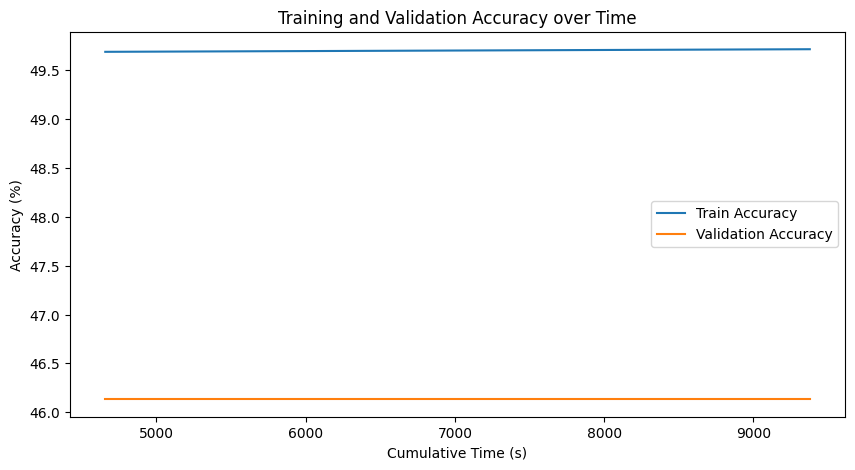


Training complete!


In [ ]:
set_seed(42)    # Set seed for reproducibility
bert_classifier, optimizer, scheduler = initialize_model(epochs=2)
train(bert_classifier, train_dataloader, val_dataloader, epochs=2, evaluation=True)

In [ ]:
set_seed(29)    # Set seed for reproducibility
bert_classifier, optimizer, scheduler = initialize_model(epochs=2)
train(bert_classifier, train_dataloader, val_dataloader, epochs=2, evaluation=True)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   0.495671   |     -      |     -     |   22.56  
   1    |   40    |   0.506065   |     -      |     -     |   23.46  
   1    |   60    |   0.506975   |     -      |     -     |   23.13  
   1    |   80    |   0.485550   |     -      |     -     |   22.12  
   1    |   100   |   0.473108   |     -      |     -     |   23.27  
   1    |   120   |   0.493723   |     -      |     -     |   22.50  
   1    |   140   |   0.440912   |     -      |     -     |   12.66  
----------------------------------------------------------------------
   1    |    -    |   0.500571   |  0.508620  |   49.64   |   46.13   |  6120.17 
----------------------------------------------------------------------
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
--------------------------------------------------------

------------

### **2. Convex Optimization**

In [ ]:
Pretrained_Bert = BertModel.from_pretrained('bert-base-uncased')
last_hidden_state_cls = np.zeros((0,768))

for i in range(np.shape(train_inputs)[0]//20):
    outputs = Pretrained_Bert(input_ids=train_inputs[i*20:(i+1)*20], attention_mask=train_masks[i*20:(i+1)*20])
    # Extract the last hidden state of the token `[CLS]` for classification task
    last_hidden_state_cls = np.concatenate((last_hidden_state_cls, outputs[0][:, 0, :].squeeze().detach().numpy()))
    print(np.shape(last_hidden_state_cls))

(20, 768)
(40, 768)
(60, 768)
(80, 768)
(100, 768)
(120, 768)
(140, 768)
(160, 768)
(180, 768)
(200, 768)
(220, 768)
(240, 768)
(260, 768)
(280, 768)
(300, 768)
(320, 768)
(340, 768)
(360, 768)
(380, 768)
(400, 768)
(420, 768)
(440, 768)
(460, 768)
(480, 768)
(500, 768)
(520, 768)
(540, 768)
(560, 768)
(580, 768)
(600, 768)
(620, 768)
(640, 768)
(660, 768)
(680, 768)
(700, 768)
(720, 768)
(740, 768)
(760, 768)
(780, 768)
(800, 768)
(820, 768)
(840, 768)
(860, 768)
(880, 768)
(900, 768)
(920, 768)
(940, 768)
(960, 768)
(980, 768)
(1000, 768)
(1020, 768)
(1040, 768)
(1060, 768)
(1080, 768)
(1100, 768)
(1120, 768)
(1140, 768)
(1160, 768)
(1180, 768)
(1200, 768)
(1220, 768)
(1240, 768)
(1260, 768)
(1280, 768)
(1300, 768)
(1320, 768)
(1340, 768)
(1360, 768)
(1380, 768)
(1400, 768)
(1420, 768)
(1440, 768)
(1460, 768)
(1480, 768)
(1500, 768)
(1520, 768)
(1540, 768)
(1560, 768)
(1580, 768)
(1600, 768)
(1620, 768)
(1640, 768)
(1660, 768)
(1680, 768)
(1700, 768)
(1720, 768)
(1740, 768)
(1760, 76

In [ ]:
Embedding_Size = 768
max_neurons = 30
num_labels = 2
training_data_np = last_hidden_state_cls
training_labels_np = y_train
#training_labels_np[training_labels_np == -1] = 0
n = np.shape(training_data_np)[0]

batch_size = n//10

In [ ]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt


def relu(x):
    return np.maximum(0,x)
def drelu(x):
    return x>=0

beta = 1e-3
learned_U1 = []
learned_U2 = []

G = np.random.randn(Embedding_Size,max_neurons)

for u in range(n//batch_size):

    training_batch_data_np = training_data_np[u*batch_size:(u+1)*batch_size]
    training_batch_labels_np = training_labels_np[u*batch_size:(u+1)*batch_size]

    dmat= drelu(np.matmul(training_batch_data_np,G))

    # Optimal CVX
    m1=dmat.shape[1]
    Uopt1=cp.Variable((Embedding_Size,m1))
    Uopt2=cp.Variable((Embedding_Size,m1))

    ## Below we use hinge loss as a performance metric for binary classification
    yopt1=cp.Parameter((batch_size,1))
    yopt2=cp.Parameter((batch_size,1))
    yopt1=cp.sum(cp.multiply(dmat,(training_batch_data_np@Uopt1)),axis=1)
    yopt2=cp.sum(cp.multiply(dmat,(training_batch_data_np@Uopt2)),axis=1)

    #hinge loss
    cost=cp.sum(cp.pos(1-cp.multiply(training_batch_labels_np,yopt1-yopt2)))/n+beta*(cp.mixed_norm(Uopt1.T,2,1)+cp.mixed_norm(Uopt2.T,2,1))
    #BCE loss
    #cost=cp.sum(cp.logistic(yopt1-yopt2) - cp.multiply(training_batch_labels_np,yopt1-yopt2))/n+beta*(cp.mixed_norm(Uopt1.T,2,1)+cp.mixed_norm(Uopt2.T,2,1))
    constraints=[]
    constraints+=[cp.multiply((2*dmat-np.ones((batch_size,m1))),(training_batch_data_np*Uopt1))>=0]
    constraints+=[cp.multiply((2*dmat-np.ones((batch_size,m1))),(training_batch_data_np*Uopt2))>=0]
    prob=cp.Problem(cp.Minimize(cost))
    prob.solve()
    cvx_opt=prob.value
    print("Convex program objective value (eq (8)): ",cvx_opt)

    learned_U1.append(Uopt1._value)
    learned_U2.append(Uopt2._value)

/usr/local/lib/python3.10/dist-packages/cvxpy/expressions/expression.py:612: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 1 times so far.

  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/cvxpy/expressions/expression.py:612: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 2 times so far.

  warnings.warn(msg, UserWarning)


Convex program objective value (eq (8)):  0.004674880729885469


/usr/local/lib/python3.10/dist-packages/cvxpy/expressions/expression.py:612: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 3 times so far.

  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/cvxpy/expressions/expression.py:612: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 4 times so far.

  warnings.warn(msg, UserWarning)


Convex program objective value (eq (8)):  0.004362714209544006


/usr/local/lib/python3.10/dist-packages/cvxpy/expressions/expression.py:612: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 5 times so far.

  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/cvxpy/expressions/expression.py:612: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 6 times so far.

  warnings.warn(msg, UserWarning)


Convex program objective value (eq (8)):  0.004621620227937792


/usr/local/lib/python3.10/dist-packages/cvxpy/expressions/expression.py:612: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 7 times so far.

  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/cvxpy/expressions/expression.py:612: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 8 times so far.

  warnings.warn(msg, UserWarning)


Convex program objective value (eq (8)):  0.004757804353277701


/usr/local/lib/python3.10/dist-packages/cvxpy/expressions/expression.py:612: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 9 times so far.

  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/cvxpy/expressions/expression.py:612: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 10 times so far.

  warnings.warn(msg, UserWarning)


Convex program objective value (eq (8)):  0.00478204570160614


/usr/local/lib/python3.10/dist-packages/cvxpy/expressions/expression.py:612: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 11 times so far.

  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/cvxpy/expressions/expression.py:612: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 12 times so far.

  warnings.warn(msg, UserWarning)


Convex program objective value (eq (8)):  0.004246686563425677


/usr/local/lib/python3.10/dist-packages/cvxpy/expressions/expression.py:612: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 13 times so far.

  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/cvxpy/expressions/expression.py:612: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 14 times so far.

  warnings.warn(msg, UserWarning)


Convex program objective value (eq (8)):  0.004579765050360665


/usr/local/lib/python3.10/dist-packages/cvxpy/expressions/expression.py:612: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 15 times so far.

  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/cvxpy/expressions/expression.py:612: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 16 times so far.

  warnings.warn(msg, UserWarning)


Convex program objective value (eq (8)):  0.0044090391202640375


/usr/local/lib/python3.10/dist-packages/cvxpy/expressions/expression.py:612: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 17 times so far.

  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/cvxpy/expressions/expression.py:612: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 18 times so far.

  warnings.warn(msg, UserWarning)


Convex program objective value (eq (8)):  0.004572388524745251


/usr/local/lib/python3.10/dist-packages/cvxpy/expressions/expression.py:612: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 19 times so far.

  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/cvxpy/expressions/expression.py:612: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 20 times so far.

  warnings.warn(msg, UserWarning)


Convex program objective value (eq (8)):  0.004479779612714447


In [ ]:
test_data_np = np.zeros((0,768))
for i in range(np.shape(val_inputs)[0]//20):
    outputs = Pretrained_Bert(input_ids=val_inputs[i*20:(i+1)*20], attention_mask=val_masks[i*20:(i+1)*20])
    # Extract the last hidden state of the token `[CLS]` for classification task
    test_data_np = np.concatenate((test_data_np, outputs[0][:, 0, :].squeeze().detach().numpy()))
    print(np.shape(test_data_np))
test_labels_np = y_val
#test_labels_np[test_labels_np == -1] = 0

(20, 768)
(40, 768)
(60, 768)
(80, 768)
(100, 768)
(120, 768)
(140, 768)
(160, 768)
(180, 768)
(200, 768)
(220, 768)
(240, 768)
(260, 768)
(280, 768)
(300, 768)
(320, 768)
(340, 768)
(360, 768)
(380, 768)
(400, 768)
(420, 768)
(440, 768)
(460, 768)
(480, 768)
(500, 768)


In [ ]:
dmat = drelu(np.matmul(test_data_np,G))
Uopt1_np = np.array(sum(learned_U1)/(n//batch_size))
Uopt2_np = np.array(sum(learned_U2)/(n//batch_size))


preds = np.sum(np.multiply(dmat, np.matmul(test_data_np, Uopt1_np-Uopt2_np)),axis = 1)

preds[preds > 0] = int(1)
#hinge loss
preds[preds < 0] = int(-1) # for Hinge


#BCE loss
#preds[preds < 0] = int(0) # for BCE

print

acc = np.sum((preds == test_labels_np))
print("Convex accuacy:"+str(acc/np.shape(test_labels_np)[0]*100)+"%")

Convex accuacy:85.6%
